# IFAC 2024 EEG signal features extraction for stress

## Libraries

In [17]:
from pathlib import Path

# Define a base directory for the dataset
if 'google.colab' in str(get_ipython()):
    # Code is running in Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    base_dir = Path('/content/drive/My Drive/Supervised-Project/Data')
    !pip install matplotlib pandas numpy ts2vg scikit-image pyfeats scikit-learn==1.2.0 lazypredict dask[dataframe]
else:
    # Code is running locally
    base_dir = Path('Data/')  # Adjust to your local relative path


In [1]:
# General use libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Visibility graph generation
from ts2vg import NaturalVG
from skimage import transform

# Features extraction
import pyfeats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyClassifier



## Functions

In [15]:
def create_VG(sig_dt, w_n, it, limit_p):
    """
    Create a visibility graph from the given signal data.

    Parameters:
    sig_dt (array-like): The signal data.
    w_n: weight scheme for the VG.
    it (int): The size to which the adjacency matrix should be resized.
    limit_p (float): The penetrable limit for the visibility graph.

    Returns:
    np.ndarray: The resized adjacency matrix as an image.
    """
    sig_n = sig_dt

    nvg = NaturalVG(weighted=w_n, penetrable_limit=limit_p).build(sig_n)

    if w_n is None:
        adm = nvg.adjacency_matrix(triangle="both", use_weights=False)
    else:
        adm = nvg.adjacency_matrix(triangle="both", use_weights=True)

    nan_mask = np.isnan(adm)
    adm[nan_mask] = 0

    images = transform.resize(adm, (it, it), anti_aliasing=True)  # Resize to speed up computation

    return adm

def split_signal_into_windows(signal, window_size, overlap_percentage):
    """
    Splits the signal into overlapping windows.

    Parameters:
    signal (array-like): The input signal to be windowed.
    window_size (int): The size of each window.
    overlap_percentage (float): The percentage of overlap between consecutive windows.

    Returns:
    tuple: A tuple containing:
        - windows (list of array-like): A list of windows.
        - num_windows (int): The number of windows created.
    """
    overlap_size = int(window_size * overlap_percentage)
    windows = []

    for start in range(0, len(signal) - window_size + 1, window_size - overlap_size):
        window = signal[start:start + window_size]
        if len(window) == window_size:
            windows.append(window)

    num_windows = len(windows)
    return windows, num_windows

def VG_feat(wind, limit_p, weight, img_size):
    """
    Extracts various features from a visibility graph created from the given window of signal data.

    Parameters:
    wind (array-like): The window of signal data.
    limit_p (float): The penetrable limit for the visibility graph.
    weight:  Weight scheme visibility graph.
    img_size (int): The size to which the adjacency matrix should be resized.

    Returns:
    tuple: A tuple containing:
        - features (np.ndarray): The extracted features.
        - labels (list of str): The labels corresponding to the features.
    """
    # Create the visibility graph image
    img = create_VG(wind, w_n=weight, it=img_size, limit_p=limit_p)
    img[img > 0] = 1  # Binarize the image

    # Zernike moments features (Binarized)
    f1_zer = img
    mask = f1_zer.copy()
    mask[mask > 0] = 1

    # Zernike moments features (Non-Binarized)
    f3_zer = img
    features_z, labels_z = pyfeats.zernikes_moments(f3_zer, radius=9)

    # Hu's moments features
    f1_hu = img
    features_hu, labels_hu = pyfeats.hu_moments(f1_hu)

    # Wavelet Packet (WP) moments features
    f1_wp = img
    features_wp, labels_wp = pyfeats.wp_features(f1_wp, mask, maxlevel=3)

    # SCSA features (commented out)
    # f1_scsa = img
    # features_scsa = SCSA2D_fet(f1_scsa, img_size)
    labels_scsa = ['K1sq_sum', 'K2sq_sum', 'K3sq_sum', 'K1r_sum', 'K1m_sum', 'N_sum', 'mean_sums', 'std_sums',
                   'INV1_sums', 'INV2_sums', 'INV3_sums', 'First_sums']

    # Combine all features and labels
    features = np.hstack((features_z.reshape(1, -1), features_hu.reshape(1, -1), features_wp.reshape(1, -1))).reshape(1, -1)
    labels = np.hstack((np.asarray(labels_z).reshape(1, -1), np.asarray(labels_hu).reshape(1, -1), np.asarray(labels_wp).reshape(1, -1))).reshape(-1,)

    return features, list(labels)

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.

    Inputs:
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output:
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

## Load EEG signal data

In [18]:
signal=np.load(f"{base_dir}/eeg_signals.npy",allow_pickle=True).item()

In [19]:
patients = list(signal.keys())
patients.remove('2105_1')
print(patients)

['2107_1', '2126_1', '2104_2', '2123_1', '2124_2', '2113_1', '2122_1', '2110_1', '2121_1', '2104_1', '2114_1', '2131_2', '2120_1', '2112_1', '2115_1', '2117_1', '2119_1', '2130_1', '2131_1', '2109_1', '2129_1', '2116_1', '2134_1', '2133_1', '2111_1', '2108_1', '2132_1', '2127_1', '2106_1', '2124_1', '2125_1', '2136_1']


## Create Visibility Graph and extract features

In [20]:
# Windowing parameters
window_size = 100  # Size of each window in samples
overlap_percentage = 0  # Percentage of overlap between consecutive windows

# Visibility graph parameters
limit_p = 0  # Penetrable limit for the visibility graph
img_size = 10  # Size to which the adjacency matrix should be resized
weight = None  # Weight scheme in the VG. Can be None or "distance"

# Sampling rates
original_rate = 250  # Original sample rate of the EEG signal (Hz)

Processes EEG signals for each patients and extracts features

In [21]:
pac_vt_EEG = {}  # Dictionary to store the feature vectors for each patient

for pa in patients:
    if not signal[pa][0]:   # Check if the patient is empty
        print(f"Patient {pa} is empty.")
    else:
        print(f"Patient {pa} is correct. Will be added to the database.")

        status = list(signal[pa][0].keys())  # List of status for each patient

        for sta in status:
            bands = list(signal[pa][0][sta][0].keys())
            fet_ban = []  # List to store feature vectors for each band
            lab_ban = []  # List to store labels for each band

            for band in bands:
                fet_chn_ban = []  # List to store feature vectors for each channel and band
                lab_chn_ban = []  # List to store labels for each channel and band

                for chn in range(4):
                    sig_pa = np.array(signal[pa][0][sta][0][band][0][:, chn]).reshape(-1,)  # Extract the EEG signal for the given patient, status, band, and channel

                    windows, windo_num = split_signal_into_windows(sig_pa, window_size, overlap_percentage)
                    values_dt = []

                    # Extract features for each window
                    for wind in windows:
                        fet, lab = VG_feat(wind, limit_p, weight, img_size)
                        lab = [s + "non" + band + str(chn) for s in lab]
                        lab_chn_ban.append(lab)  # Append labels for each channel
                        values_dt.append(fet.copy().reshape(-1,))

                    mean_ft = np.mean(np.asarray(values_dt), axis=0)  # Calculate the mean feature vector for each channel
                    fet_chn_ban.append(mean_ft.reshape(-1, 1))  # Append mean feature vectors for each channel

                fet_ban.append(np.concatenate(fet_chn_ban, axis=0))  # Concatenate feature vectors for each band
                lab_ban.append(np.concatenate(lab_chn_ban, axis=0))  # Concatenate labels for each band

            fts = np.asarray(fet_ban).flatten()
            lbs = np.asarray(lab_ban).flatten()
            dt_mean = np.hstack((fts, sta))
            pac_vt_EEG[f"{pa}_{sta}"] = [np.asarray(dt_mean)]  # Store the feature vectors for each patient and status


Patient 2107_1 is correct. Will be added to the database.
Patient 2126_1 is correct. Will be added to the database.
Patient 2104_2 is correct. Will be added to the database.
Patient 2123_1 is correct. Will be added to the database.
Patient 2124_2 is correct. Will be added to the database.
Patient 2113_1 is correct. Will be added to the database.
Patient 2122_1 is correct. Will be added to the database.
Patient 2110_1 is correct. Will be added to the database.
Patient 2121_1 is correct. Will be added to the database.
Patient 2104_1 is empty.
Patient 2114_1 is correct. Will be added to the database.
Patient 2131_2 is correct. Will be added to the database.
Patient 2120_1 is correct. Will be added to the database.
Patient 2112_1 is correct. Will be added to the database.
Patient 2115_1 is correct. Will be added to the database.
Patient 2117_1 is correct. Will be added to the database.
Patient 2119_1 is correct. Will be added to the database.
Patient 2130_1 is correct. Will be added to the

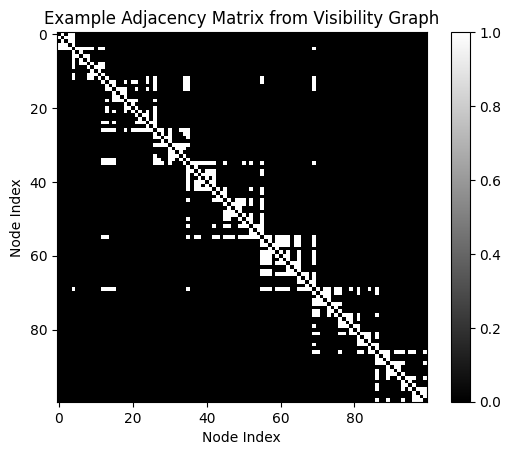

In [22]:
# Example:
example_patient = list(signal.keys())[0]
example_status = list(signal[example_patient][0].keys())[0]
example_band = list(signal[example_patient][0][example_status][0].keys())[0]
example_channel = 0

example_signal = np.array(signal[example_patient][0][example_status][0][example_band][0][:, example_channel]).reshape(-1,)
windows, _ = split_signal_into_windows(example_signal, window_size, overlap_percentage)

example_window = windows[0]  # Choose the first window as an example

example_adm = create_VG(example_window, w_n=weight, it=img_size, limit_p=limit_p)

# Plot the adjacency matrix
plt.imshow(example_adm, cmap='gray')
plt.title('Example Adjacency Matrix from Visibility Graph')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.colorbar()
plt.show()

Create DataFrame for the extraxed features

In [23]:
# Convert the dictionary of feature vectors into a DataFrame
features_EEG = pd.DataFrame({key: pd.Series(value[0]) for key, value in pac_vt_EEG.items()})

# Transpose the DataFrame to have patients as rows and features as columns
features_EEG = features_EEG.T

# Set the column names of the DataFrame to the feature labels and add a "Labels" column
features_EEG.columns = np.hstack((lbs, "Labels"))

# Display the first few rows of the DataFrame
features_EEG.head()

,Zernikes_Moments_radius_9_0nonTheta0,Zernikes_Moments_radius_9_1nonTheta0,Zernikes_Moments_radius_9_2nonTheta0,Zernikes_Moments_radius_9_3nonTheta0,Zernikes_Moments_radius_9_4nonTheta0,Zernikes_Moments_radius_9_5nonTheta0,Zernikes_Moments_radius_9_6nonTheta0,Zernikes_Moments_radius_9_7nonTheta0,Zernikes_Moments_radius_9_8nonTheta0,Zernikes_Moments_radius_9_9nonTheta0,...,WP_coif1_dvd_stdnonGamma3,WP_coif1_dda_meannonGamma3,WP_coif1_dda_stdnonGamma3,WP_coif1_ddh_meannonGamma3,WP_coif1_ddh_stdnonGamma3,WP_coif1_ddv_meannonGamma3,WP_coif1_ddv_stdnonGamma3,WP_coif1_ddd_meannonGamma3,WP_coif1_ddd_stdnonGamma3,Labels
2107_1_10,0.31830988618379025,0.02161592415644246,0.22663369946281822,0.11243145293247059,0.0052985291671055895,0.00952069636502332,0.03541282823776017,0.0985461131799324,0.19348913654219113,0.09872958646101868,...,0.1669548467895343,0.10515635731775635,0.19450164290923816,0.0927629182430819,0.14986803047461084,0.09276291824308193,0.14986803047461086,0.17889314887017724,0.34455558263992964,10
2107_1_20,0.31830988618379025,0.02161592415644246,0.22663369946281822,0.11243145293247059,0.0052985291671055895,0.00952069636502332,0.03541282823776017,0.0985461131799324,0.19348913654219113,0.09872958646101868,...,0.1669548467895343,0.10515635731775635,0.19450164290923816,0.0927629182430819,0.14986803047461084,0.09276291824308193,0.14986803047461086,0.17889314887017724,0.34455558263992964,20
2107_1_16,0.31830988618379025,0.02161592415644246,0.22663369946281822,0.11243145293247059,0.0052985291671055895,0.00952069636502332,0.03541282823776017,0.0985461131799324,0.19348913654219113,0.09872958646101868,...,0.1669548467895343,0.10515635731775635,0.19450164290923816,0.0927629182430819,0.14986803047461084,0.09276291824308193,0.14986803047461086,0.17889314887017724,0.34455558263992964,16
2107_1_26,0.31830988618379025,0.02161592415644246,0.22663369946281822,0.11243145293247059,0.0052985291671055895,0.00952069636502332,0.03541282823776017,0.0985461131799324,0.19348913654219113,0.09872958646101868,...,0.1669548467895343,0.10515635731775635,0.19450164290923816,0.0927629182430819,0.14986803047461084,0.09276291824308193,0.14986803047461086,0.17889314887017724,0.34455558263992964,26
2107_1_10_1,0.31830988618379025,0.02161592415644246,0.22663369946281822,0.11243145293247059,0.0052985291671055895,0.00952069636502332,0.03541282823776017,0.0985461131799324,0.19348913654219113,0.09872958646101868,...,0.1669548467895343,0.10515635731775635,0.19450164290923816,0.0927629182430819,0.14986803047461084,0.09276291824308193,0.14986803047461086,0.17889314887017724,0.34455558263992964,10_1


In [24]:
features=features_EEG.dropna()  # Remove rows with missing values
features.head()

,Zernikes_Moments_radius_9_0nonTheta0,Zernikes_Moments_radius_9_1nonTheta0,Zernikes_Moments_radius_9_2nonTheta0,Zernikes_Moments_radius_9_3nonTheta0,Zernikes_Moments_radius_9_4nonTheta0,Zernikes_Moments_radius_9_5nonTheta0,Zernikes_Moments_radius_9_6nonTheta0,Zernikes_Moments_radius_9_7nonTheta0,Zernikes_Moments_radius_9_8nonTheta0,Zernikes_Moments_radius_9_9nonTheta0,...,WP_coif1_dvd_stdnonGamma3,WP_coif1_dda_meannonGamma3,WP_coif1_dda_stdnonGamma3,WP_coif1_ddh_meannonGamma3,WP_coif1_ddh_stdnonGamma3,WP_coif1_ddv_meannonGamma3,WP_coif1_ddv_stdnonGamma3,WP_coif1_ddd_meannonGamma3,WP_coif1_ddd_stdnonGamma3,Labels
2107_1_10,0.31830988618379025,0.02161592415644246,0.22663369946281822,0.11243145293247059,0.0052985291671055895,0.00952069636502332,0.03541282823776017,0.0985461131799324,0.19348913654219113,0.09872958646101868,...,0.1669548467895343,0.10515635731775635,0.19450164290923816,0.0927629182430819,0.14986803047461084,0.09276291824308193,0.14986803047461086,0.17889314887017724,0.34455558263992964,10
2107_1_20,0.31830988618379025,0.02161592415644246,0.22663369946281822,0.11243145293247059,0.0052985291671055895,0.00952069636502332,0.03541282823776017,0.0985461131799324,0.19348913654219113,0.09872958646101868,...,0.1669548467895343,0.10515635731775635,0.19450164290923816,0.0927629182430819,0.14986803047461084,0.09276291824308193,0.14986803047461086,0.17889314887017724,0.34455558263992964,20
2107_1_16,0.31830988618379025,0.02161592415644246,0.22663369946281822,0.11243145293247059,0.0052985291671055895,0.00952069636502332,0.03541282823776017,0.0985461131799324,0.19348913654219113,0.09872958646101868,...,0.1669548467895343,0.10515635731775635,0.19450164290923816,0.0927629182430819,0.14986803047461084,0.09276291824308193,0.14986803047461086,0.17889314887017724,0.34455558263992964,16
2107_1_26,0.31830988618379025,0.02161592415644246,0.22663369946281822,0.11243145293247059,0.0052985291671055895,0.00952069636502332,0.03541282823776017,0.0985461131799324,0.19348913654219113,0.09872958646101868,...,0.1669548467895343,0.10515635731775635,0.19450164290923816,0.0927629182430819,0.14986803047461084,0.09276291824308193,0.14986803047461086,0.17889314887017724,0.34455558263992964,26
2107_1_10_1,0.31830988618379025,0.02161592415644246,0.22663369946281822,0.11243145293247059,0.0052985291671055895,0.00952069636502332,0.03541282823776017,0.0985461131799324,0.19348913654219113,0.09872958646101868,...,0.1669548467895343,0.10515635731775635,0.19450164290923816,0.0927629182430819,0.14986803047461084,0.09276291824308193,0.14986803047461086,0.17889314887017724,0.34455558263992964,10_1


Save the feature vectors to a CSV file

In [25]:
features.to_csv('EEG_features_100.csv')  # Save the feature vectors to a CSV file

In [48]:
features_num=features.iloc[:,0:-1]
features_num= features_num.astype(float)

## Preprocess features

In [49]:
nan_columns = features_num.columns[features_num.isna().any()].tolist()  # Find columns with NaN values

print("Columns with NaN values:")
print(nan_columns)

Columns with NaN values:
[]


In [50]:
nan_rows = features_num[features_num.isna().any(axis=1)]  # Find rows with NaN values

print("Rows with NaN values:")
print(nan_rows)

Rows with NaN values:
Empty DataFrame
Columns: [Zernikes_Moments_radius_9_0nonTheta0, Zernikes_Moments_radius_9_1nonTheta0, Zernikes_Moments_radius_9_2nonTheta0, Zernikes_Moments_radius_9_3nonTheta0, Zernikes_Moments_radius_9_4nonTheta0, Zernikes_Moments_radius_9_5nonTheta0, Zernikes_Moments_radius_9_6nonTheta0, Zernikes_Moments_radius_9_7nonTheta0, Zernikes_Moments_radius_9_8nonTheta0, Zernikes_Moments_radius_9_9nonTheta0, Zernikes_Moments_radius_9_10nonTheta0, Zernikes_Moments_radius_9_11nonTheta0, Zernikes_Moments_radius_9_12nonTheta0, Zernikes_Moments_radius_9_13nonTheta0, Zernikes_Moments_radius_9_14nonTheta0, Zernikes_Moments_radius_9_15nonTheta0, Zernikes_Moments_radius_9_16nonTheta0, Zernikes_Moments_radius_9_17nonTheta0, Zernikes_Moments_radius_9_18nonTheta0, Zernikes_Moments_radius_9_19nonTheta0, Zernikes_Moments_radius_9_20nonTheta0, Zernikes_Moments_radius_9_21nonTheta0, Zernikes_Moments_radius_9_22nonTheta0, Zernikes_Moments_radius_9_23nonTheta0, Zernikes_Moments_radius_9_

Remove Collinear features

In [27]:
# Load the CSV file into a DataFrame
features = pd.read_csv('EEG_features_100.csv', index_col=0)

# Display the first few rows of the DataFrame
features.head()

,Zernikes_Moments_radius_9_0nonTheta0,Zernikes_Moments_radius_9_1nonTheta0,Zernikes_Moments_radius_9_2nonTheta0,Zernikes_Moments_radius_9_3nonTheta0,Zernikes_Moments_radius_9_4nonTheta0,Zernikes_Moments_radius_9_5nonTheta0,Zernikes_Moments_radius_9_6nonTheta0,Zernikes_Moments_radius_9_7nonTheta0,Zernikes_Moments_radius_9_8nonTheta0,Zernikes_Moments_radius_9_9nonTheta0,...,WP_coif1_dvd_stdnonGamma3,WP_coif1_dda_meannonGamma3,WP_coif1_dda_stdnonGamma3,WP_coif1_ddh_meannonGamma3,WP_coif1_ddh_stdnonGamma3,WP_coif1_ddv_meannonGamma3,WP_coif1_ddv_stdnonGamma3,WP_coif1_ddd_meannonGamma3,WP_coif1_ddd_stdnonGamma3,Labels
2107_1_10,0.32,0.02,0.23,0.11,0.01,0.01,0.04,0.10,0.19,0.10,...,0.17,0.11,0.19,0.09,0.15,0.09,0.15,0.18,0.34,10
2107_1_20,0.32,0.02,0.23,0.11,0.01,0.01,0.04,0.10,0.19,0.10,...,0.17,0.11,0.19,0.09,0.15,0.09,0.15,0.18,0.34,20
2107_1_16,0.32,0.02,0.23,0.11,0.01,0.01,0.04,0.10,0.19,0.10,...,0.17,0.11,0.19,0.09,0.15,0.09,0.15,0.18,0.34,16
2107_1_26,0.32,0.02,0.23,0.11,0.01,0.01,0.04,0.10,0.19,0.10,...,0.17,0.11,0.19,0.09,0.15,0.09,0.15,0.18,0.34,26
2107_1_10_1,0.32,0.02,0.23,0.11,0.01,0.01,0.04,0.10,0.19,0.10,...,0.17,0.11,0.19,0.09,0.15,0.09,0.15,0.18,0.34,10_1


In [28]:
# Compute correlation matrix

df_filtered = remove_collinear_features(features.drop(columns=['Labels']), 0.6)  # Do not include the "Labels" column in the correlation analysis

Removed Columns {'WP_coif1_vhd_stdnonAlpha_low3', 'WP_coif1_ddd_stdnonTheta0', 'WP_coif1_hvv_meannonGamma0', 'WP_coif1_hav_stdnonTheta0', 'WP_coif1_add_meannonAlpha_high2', 'WP_coif1_avh_stdnonAlpha_high2', 'WP_coif1_hah_stdnonGamma3', 'WP_coif1_avv_meannonBeta2', 'WP_coif1_vdv_stdnonAlpha_low1', 'WP_coif1_hhv_meannonBeta0', 'WP_coif1_adv_meannonAlpha_high3', 'WP_coif1_ahv_meannonAlpha_low2', 'WP_coif1_dhv_meannonAlpha_low2', 'WP_coif1_vdv_meannonTheta2', 'Zernikes_Moments_radius_9_13nonGamma1', 'WP_coif1_hav_stdnonGamma0', 'Hu_Moment_4nonAlpha_low1', 'WP_coif1_hha_meannonBeta2', 'WP_coif1_ava_meannonAlpha_low0', 'WP_coif1_dad_meannonTheta2', 'WP_coif1_hvd_meannonTheta1', 'WP_coif1_vvd_stdnonBeta1', 'WP_coif1_vhd_stdnonGamma1', 'WP_coif1_avd_stdnonTheta0', 'Zernikes_Moments_radius_9_11nonAlpha_high1', 'WP_coif1_ada_stdnonTheta2', 'WP_coif1_hvv_meannonBeta0', 'WP_coif1_hvv_stdnonAlpha_low0', 'Hu_Moment_4nonBeta3', 'WP_coif1_vdh_stdnonBeta0', 'Zernikes_Moments_radius_9_13nonAlpha_high1',

## K-Means Clustering

Standardise features

In [ ]:
data = df_filtered.values
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [ ]:
df_filtered.shape

(666, 84)

In [ ]:
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=0)  # Assuming 2 clusters
kmeans.fit(data)

# Get cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_



## PCA Visualization of Clusters

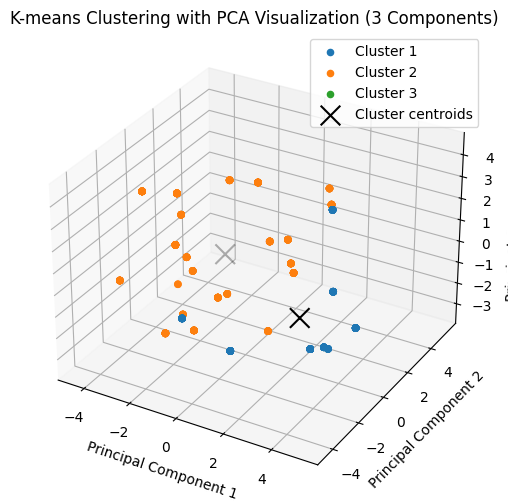

In [ ]:
n_components = 3
# Visualize the clustered data using PCA for dimensionality reduction
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(data)


# Plotting the clustered data
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points with different colors for each cluster
for i in range(n_components):
    ax.scatter(X_pca[kmeans.labels_ == i, 0], X_pca[kmeans.labels_ == i, 1], X_pca[kmeans.labels_ == i, 2], label=f'Cluster {i+1}')

# Plotting the centroids of the clusters
centroids_pca = pca.transform(kmeans.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2], marker='x', s=200, c='black', label='Cluster centroids')

# Adding labels and title
ax.set_title(f'K-means Clustering with PCA Visualization ({n_components} Components)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.grid(True)
plt.show()


## Train-Test Split

In [29]:
df_filtered['target']=features['Labels']  # Add the target column to the DataFrame
df_filtered= df_filtered[~df_filtered.index.str.contains('20|10')]  # Remove the rows with the target values "20" and "10"

unique_patients = df_filtered.index.unique()

train_patients, test_patients = train_test_split(unique_patients, test_size=0.3, random_state=42)

train_data = []
test_data = []

# Split the data into training and testing sets
for patient_id in train_patients:
    patient_data = df_filtered.loc[patient_id,:]
    train_data.append(patient_data)

for patient_id in test_patients:
    patient_data = df_filtered.loc[patient_id,:]
    test_data.append(patient_data)

# Convert the training and testing data to DataFrames
train_data_df=pd.DataFrame(train_data)
test_data_df=pd.DataFrame(test_data)


X_train = train_data_df.drop(columns=['target'])  # Only features
y_train = train_data_df['target']  # Only target

X_test = test_data_df.drop(columns=['target'])
y_test = test_data_df['target']

*Participants answered their stress levels on a 21-point Likert scale.*

In [53]:
y_train.head()

2124_2_23    23
2119_1_24    24
2117_1_16    16
2133_1_22    22
2126_1_24    24
Name: target, dtype: object

## Label Transformation


*All answers with stress < 14 have been considered as no stress, while answers with stress >= 14 have been considered as stress.*

In [30]:
def change_labels(labels):
    new_labels = []
    for label in labels:
        label = int(label)
        if label < 14:
            new_labels.append(0)
        else:
            new_labels.append(1)
    return new_labels

y_train = change_labels(y_train)

y_test = change_labels(y_test)

## Feature Selection

In [31]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

selec=SelectKBest(f_classif, k=20)

X_train_sel= selec.fit_transform(X_train, y_train)
X_test_sel= selec.transform(X_test)

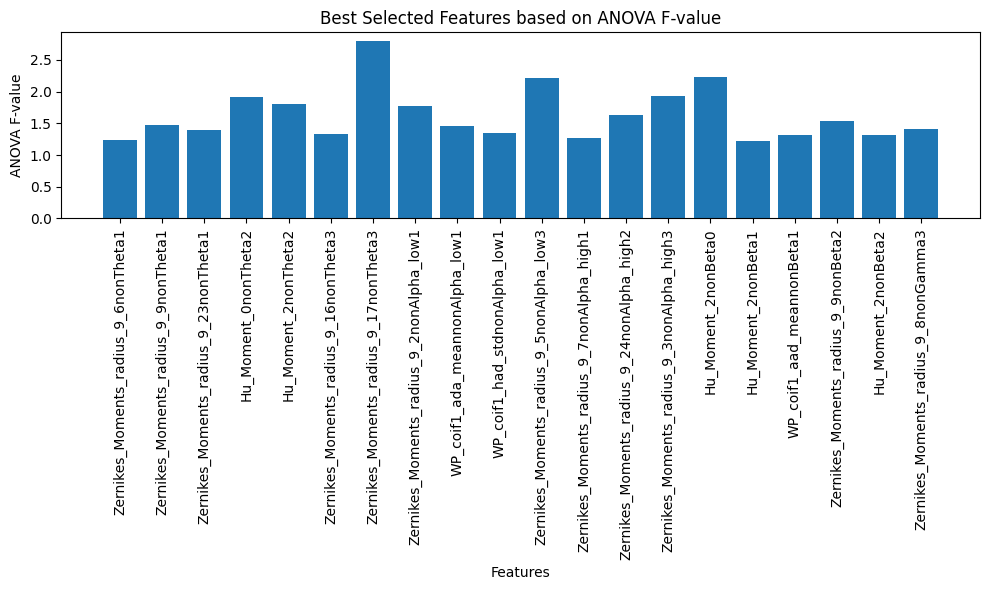

In [32]:
selected_feature_indices = selec.get_support(indices=True)
selected_feature_names = df_filtered.columns[selected_feature_indices].tolist()

# Create a bar plot of the selected features
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_feature_names)), selec.scores_[selected_feature_indices])
plt.xticks(range(len(selected_feature_names)), selected_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('ANOVA F-value')
plt.title('Best Selected Features based on ANOVA F-value')
plt.tight_layout()
plt.show()

In [57]:
print("Sample of selected features:")
selected_features_df = pd.DataFrame(X_train_sel[:5, :], columns=selected_feature_names)
selected_features_df

Sample of selected features:


,Zernikes_Moments_radius_9_4nonTheta0,Zernikes_Moments_radius_9_18nonTheta0,Zernikes_Moments_radius_9_24nonTheta1,Zernikes_Moments_radius_9_24nonTheta2,Zernikes_Moments_radius_9_3nonTheta3,Zernikes_Moments_radius_9_20nonTheta3,WP_coif1_aad_meannonTheta3,Zernikes_Moments_radius_9_19nonAlpha_low0,WP_coif1_aad_meannonAlpha_low0,Zernikes_Moments_radius_9_16nonAlpha_low1,Zernikes_Moments_radius_9_1nonAlpha_low3,Zernikes_Moments_radius_9_21nonAlpha_low3,Zernikes_Moments_radius_9_20nonAlpha_high0,Zernikes_Moments_radius_9_13nonAlpha_high1,Zernikes_Moments_radius_9_14nonAlpha_high3,Zernikes_Moments_radius_9_12nonBeta0,Zernikes_Moments_radius_9_4nonBeta2,Zernikes_Moments_radius_9_2nonGamma2,Zernikes_Moments_radius_9_21nonGamma2,Zernikes_Moments_radius_9_0nonGamma3
0,1.01,-1.04,-0.84,-1.18,0.73,0.97,-0.18,1.11,1.53,-0.03,0.60,1.20,1.53,-0.08,0.92,-1.17,-0.51,0.99,-0.93,-0.00
1,-0.75,-1.32,-0.22,-1.01,0.38,0.59,1.20,0.22,-0.22,0.16,0.85,0.58,0.26,1.51,0.44,1.01,0.20,-0.51,0.54,-0.00
2,1.85,-1.21,-1.71,2.75,1.33,1.37,0.40,-1.31,-0.41,-0.93,0.13,1.10,-0.27,-1.32,-0.10,-0.94,0.08,-1.57,0.53,0.00
3,-0.57,-0.32,0.34,-0.40,-1.64,2.18,-1.55,0.80,0.12,-0.90,-0.87,0.67,1.28,-0.84,-0.98,-0.42,0.23,-0.01,-0.60,-0.00
4,1.80,0.23,0.63,0.07,-1.63,-0.64,-1.10,1.73,1.44,-1.57,1.11,-1.29,-0.54,-0.46,1.35,0.17,-0.41,-0.80,-0.14,-0.00


## Model Training and Evaluation

In [58]:
# Fit all models
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_sel, X_test_sel, y_train, y_test)
models

100%|██████████| 31/31 [00:01<00:00, 20.17it/s]

[LightGBM] [Info] Number of positive: 125, number of negative: 43
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 168, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.744048 -> initscore=1.067114
[LightGBM] [Info] Start training from score 1.067114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
Perceptron,0.64,0.56,0.56,0.64,0.01
PassiveAggressiveClassifier,0.62,0.54,0.54,0.62,0.02
NuSVC,0.47,0.53,0.53,0.48,0.02
LGBMClassifier,0.70,0.50,0.50,0.57,0.06
XGBClassifier,0.70,0.50,0.50,0.57,0.21
CalibratedClassifierCV,0.70,0.50,0.50,0.57,0.09
SVC,0.70,0.50,0.50,0.57,0.02
DummyClassifier,0.70,0.50,0.50,0.57,0.02
SGDClassifier,0.70,0.50,0.50,0.57,0.02
